In [1]:
#NBVAL_SKIP
from rubix.core.pipeline import RubixPipeline 
import os
config = {
    "pipeline":{"name": "calc_ifu"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 14,
        "reuse": True,
        },
        
        "subset": {
            "use_subset": True,
            "subset_size": 10000,
        },
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-14.hdf5",
        },
    
    },
    "output_path": "output",

    "telescope":
        {"name": "MUSE"},
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1},
        
    "ssp": {
        "template": {
            "name": "BruzualCharlot2003"
        },
    },        
}

pipe = RubixPipeline(config)

data= pipe.run()

2024-06-02 13:06:03,116 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <  
/_/|_|\____/____/___/_/|_|  
                            

2024-06-02 13:06:03,117 - rubix - INFO - Rubix version: 0.0.1.post55+g93a544d
/home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/factory.py:21: UserWarning: No telescope config provided, using default stored in /home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2024-06-02 13:06:03,551 - rubix - INFO - Getting rubix data...
2024-06-02 13:06:03,552 - rubix - INFO - Rubix galaxy file already exists, skipping conversion
2024-06-02 13:06:05,616 - rubix - WARNING - The Subset value is set in config. Using only subset of size 10000
2024-06-02 13:06:05,618 - rubix - INFO - Data loaded with 10000 particles.
2024-06-02 13:06:05,619 - rubix - DEBUG - Data Shape: {'coords': (10000, 3), 'velocities': (10000, 3), 'metallicity': (10000,), 'mass': (10000,),

rotating galaxy:  face-on


2024-06-02 13:06:06,241 - rubix - DEBUG - Calculation Finished! Spectra shape: (1, 10000, 842)
2024-06-02 13:06:06,242 - rubix - INFO - Scaling Spectra by Mass...
2024-06-02 13:06:06,248 - rubix - DEBUG - Doppler Shifted SSP Wave: (1, 10000, 842)
2024-06-02 13:06:06,248 - rubix - DEBUG - Telescope Wave Seq: (3721,)
2024-06-02 13:06:06,344 - rubix - INFO - Calculating Data Cube...
2024-06-02 13:06:06,347 - rubix - DEBUG - Datacube Shape: (25, 25, 3721)
2024-06-02 13:06:10,244 - rubix - INFO - Pipeline run completed in 4.62 seconds.


In [2]:
data["datacube"].shape

(25, 25, 3721)

In [2]:
data["spectra"].shape

(1, 10000, 3721)

In [3]:
data["pixel_assignment"].max()

Array(624, dtype=int32)

In [4]:
from rubix.spectra.ifu import calculate_cube

calculate_cube(spectra=data["spectra"][0], spaxel_index=data["pixel_assignment"], num_spaxels=25)

Array([[[3.98579727e+04, 3.98269883e+04, 3.97960078e+04, ...,
         5.97114648e+03, 5.95160400e+03, 5.93206201e+03],
        [4.95685156e+03, 4.95266797e+03, 4.94848340e+03, ...,
         6.18111389e+02, 6.16388916e+02, 6.14666504e+02],
        [2.32873047e+03, 2.32680835e+03, 2.32488672e+03, ...,
         2.40254898e+02, 2.39825058e+02, 2.39395218e+02],
        ...,
        [1.32434082e+03, 1.32354333e+03, 1.32274573e+03, ...,
         4.25761292e+02, 4.24623566e+02, 4.23485840e+02],
        [5.40547363e+03, 5.40141113e+03, 5.39734912e+03, ...,
         8.70648132e+02, 8.67963318e+02, 8.65278564e+02],
        [2.37800938e+04, 2.37606738e+04, 2.37412578e+04, ...,
         3.14380347e+03, 3.13439209e+03, 3.12498047e+03]],

       [[1.85215955e+03, 1.85052612e+03, 1.84889270e+03, ...,
         2.11793976e+02, 2.11409714e+02, 2.11025436e+02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

(1, 10000, 3721)


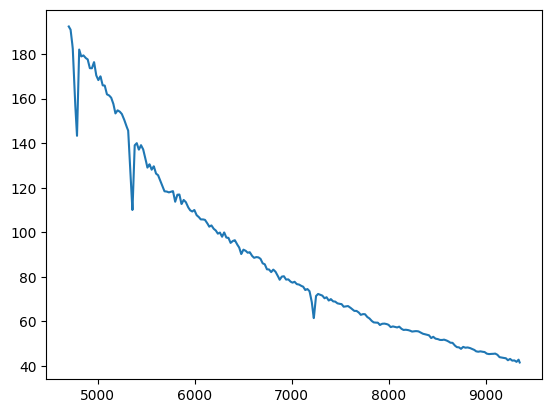

In [3]:
#NBVAL_SKIP
import matplotlib.pyplot as plt
wave = pipe.telescope.wave_seq
spectra = data["spectra"] # Spectra of all stars
print(spectra.shape)

plt.plot(wave, spectra[0,3]) 


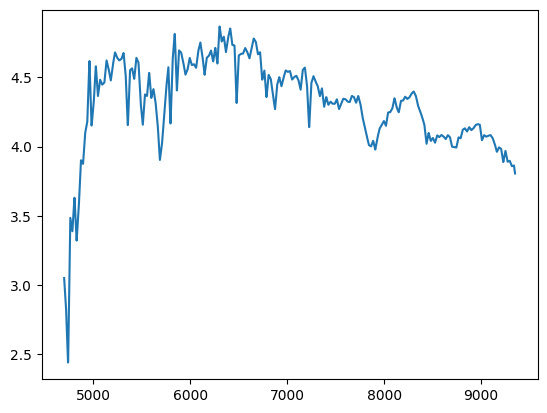

In [21]:
datacube = data["datacube"]
plt.plot(wave, datacube[0,15])

Some of the spectra may be zero, this happens if the metallicity or age values are outside the range of the SSP model. This is currently the expected behavior

In [ ]:
#NBVAL_SKIP
import jax 
import jax.numpy as jnp
# Create a function to calculate a single IFU cube
def calculate_ifu_cube(stars_spectra, pixel_indices):
    # Create an IFU cube of shape (25*25, 842)
    #ifu_cube = jnp.zeros((25 * 25, 842))
    
    # Use jax.ops.segment_sum to sum the spectra into the IFU cube based on pixel indices
    ifu_cube = jax.ops.segment_sum(stars_spectra, pixel_indices, num_segments=25*25)
    
    # Reshape the IFU cube to the desired shape (25, 25, 842)
    ifu_cube = ifu_cube.reshape((25, 25, 3721))
    
    return ifu_cube

spectra = data["spectra"]
assignments = data["pixel_assignment"]

# Calculate 4 individual IFU cubes
ifu_cubes = jax.vmap(calculate_ifu_cube)(spectra, assignments)

# Sum the 4 IFU cubes
final_ifu_cube = jnp.sum(ifu_cubes, axis=0)
final_ifu_cube.shape

In [ ]:
#NBVAL_SKIP
wavelengths = pipe.telescope.wave_seq

# get the indices of the visible wavelengths of 4000-8000 Angstroms

visible_indices = jnp.where((wavelengths >= 4000) & (wavelengths <= 8000))



In [ ]:
#NBVAL_SKIP
wavelengths

In [ ]:
#NBVAL_SKIP
spectra[0,7]

In [ ]:
#NBVAL_SKIP
# plot example spectrum
import matplotlib.pyplot as plt

spec = final_ifu_cube[12, 12]

plt.plot(wavelengths[visible_indices], spec[visible_indices])
plt.yscale("log")

In [ ]:
#NBVAL_SKIP
# get the spectra of the visible wavelengths from the ifu cube
visible_spectra = final_ifu_cube[:, :, visible_indices[0]]
visible_spectra.shape

In [ ]:
#NBVAL_SKIP
# Sum up all spectra to create an image
image = jnp.sum(visible_spectra, axis = 2)
plt.imshow(image, origin="lower", cmap="inferno")
plt.colorbar()